## 0. Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Selecao de caracteristicas e encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Importar metrica
from sklearn.feature_selection import chi2

## 1. Carregamento dos dados

In [2]:
df = pd.read_csv("covid_11_marco_limpo.csv", sep=';')

## 2.  *Feature Encoding*

Como modelos de *machine learning* performam algebra linear em matrizes, precisamos que todas as variáveis estejam como valores numericos. O processo de conversão de variaveis categoricas em numéricas é chamado de *Encoding*. Existem algumas abordagens para converter os dados categóricos em numéricos, para que o modelo possa entendê-los. Veremos os dois métodos: **Label encoding** e **One-Hot encoding**.

- Label Encoding: Recomendado quando lidamos com variáveis categóricas ordinais: Consiste em *designar um valor inteiro* (0, 1, 2, ...) oara cada valor unico da coluna.
- One-hot encoding: Consiste em *criar uma nova coluna* para cada valor único de uma coluna existente.

Material complementar:
- [Um guia (simples) de como tratar variáveis categóricas em Machine Learning](https://medium.com/@nelson.ewert.oliveira/um-guia-simples-de-como-tratar-vari%C3%A1veis-categ%C3%B3ricas-em-machine-learning-b791a00da805)
- [One-Hot Encoding vs. Label Encoding using Scikit-Learn](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/)
- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)

Para nosso contexto, vamos utilizar o **label encoding**.


Antes de transformar em labels, vamos ter certeza que a ordem das idades está correta. Vamos fazer isso transformando a coluna em 'Categorical' e afirmando a ordem.

In [3]:
df['FAIXAETARIA'].value_counts()

30 a 39      88558
20 a 29      73423
40 a 49      70883
50 a 59      57459
60 a 69      37995
70 a 79      19687
15 a 19      14916
80 e mais    10950
10 a 14       5041
05 a 09       2933
01 a 04       2324
<1            1262
Name: FAIXAETARIA, dtype: int64

In [4]:
df['FAIXAETARIA'] = pd.Categorical(df['FAIXAETARIA'], 
                      categories=["<1","01 a 04","05 a 09","10 a 14", "15 a 19", "20 a 29", 
                                  '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 e mais'],
                      ordered=True)

In [5]:
df = df.apply(LabelEncoder().fit_transform)

df.head()

,SEXO,FAIXAETARIA,OBITO,FEBRE,TOSSE,GARGANTA,DISPNEIA,GESTANTE,RACA_COR,CARDIOPATIA,...,DOENCA_RESPIRATORIA,DOENCA_NEUROLOGICA,PROBLEMA_RENAL,OBESIDADE,IMUNODEFICIENCIA,IMUNOSSUPRESSAO,HEPATITE,DOENCA_CROMOSSOMICA,DOENCA_HEMATOLOGICA,PUERPERA
0,0,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,7,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,6,0,1,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Seleção / Redução de características

Uma vez que temos as nossas *features* prontas para uso, talvez podemos achar que o número de *features* disponíveis é muito grande para treinar modelos de machine learning em um tempo rasoável. Isto também impacta na complexidade dos modelos. Existem algumas opções disponíveis para redução de características e seleção de características (*feature reduction* e *feature selection*).

 - Redução de dimensionalidade (*Dimensionality Reduction*):
     - Análise do componente principal (PCA - *Principal Component Analysis*): É um método estatístico que usa transformação ortogonal para converter um conjunto de observações de variáveis possivelmente correlacionadas em um conjunto de valores de valores de variaveis linearmente não-correlacionadas, chamado de componentes principais. Esta transformação é definida de tal forma que o primeiro componente principal tem a maior variância possível (ou seja, é responsável pelo máximo possível da variabilidade nos dados), e cada componente sucessivo, por sua vez, tem a maior variância possível sob a restrição que é ortogonal aos componentes anteriores.
     - Decomposição do Valor Singular (SVD - *Singular Value Decomposition*): É uma fatorização de uma matriz real ou complexa. É a generalização da decomposição automática de uma matriz normal semidefinida positiva (*e.g.* uma matriz simétrica com autovalores positivos) para qualquer matriz m x n por meio de uma extensão da decomposição polar. Ele tem muitas aplicações úteis em processamento de sinais e estatísticas.
 - Importância/relevância de características (*Feature Importance/Relevance*):
     - Métodos de filtragem (*Filter Methods*): Métodos de filtragem de tipo selecionam características baseadas apenas em méticas gerais, tipo correlação desta variável com a variável preditora. Métodos de filtragem suprimem as variáveis menos "interessantes". Esse método é particularmente efetivo em tempo de computação e trás robustêz contra *overfitting*.
     - Métodos de invólucro (*Wrapper methods*): São utilizados para avaliar subconjuntos de variáveis que possibilitam (diferentemente dos metodos de filtragem) detectar possíveis interações entre variáveis. As duas principais desvantagens desses métodos são: (1) aumento do risco de *overfitting* quando o número de amostras é pequeno ou insuficiente. (2) Aumento significativo do tempo de conputação quando o número de variáveis é grande.
     - Métodos imbutidos (*Embedded Methods*): Tentam combinar a vantagem dos dois métodos anteriores. Um algoritmo de aprendizagem toma vantagem do seu próprio processo de seleção de variáveis e executa a seleção de caraterísticas e classificação simultâneamente.
     
#### Correlação entre as características

Os coeficientes de correlação é a medida do quanto duas variáveis aleatóricas mudam juntas. O que a correlação procura entender é como uma variável se comporta em um cenário onde outra está variando, visando identificar se existe alguma relação entre a variabilidade de ambas. Embora não implique em causalidade, o coeficiente de correlação exprime em números essa relação, ou seja, quantifica a relação entre as variáveis. Em suma, **é o quanto uma variável está ligada a outra.**

O coeficiente de correlação de Pearson (r), também chamado de correlação linear ou r de Pearson, é um grau de relação entre duas variáveis quantitativas e exprime o grau de correlação através de valores situados entre -1 e 1.

Quando  o coeficiente de correlação se aproxima de 1, nota-se um aumento no valor de uma variável quando a outra também aumenta, ou seja, há uma relação linear positiva. Quando o coeficiente se aproxima de -1, também é possível dizer que as variáveis são correlacionadas, mas nesse caso quando o valor de uma variável aumenta o da outra diminui. Isso é o que é chamado de correlação negativa ou inversa.

Características podem estar não-correlacionadas ou correlacionadas com a característica que estamos predizer.

Para critério de inclusão e de importância de características, vamos observar apenas as variáveis que possuem um coeficiente >= +- 0.1 com relação a nossa variável predita (ÓBITO).  
     

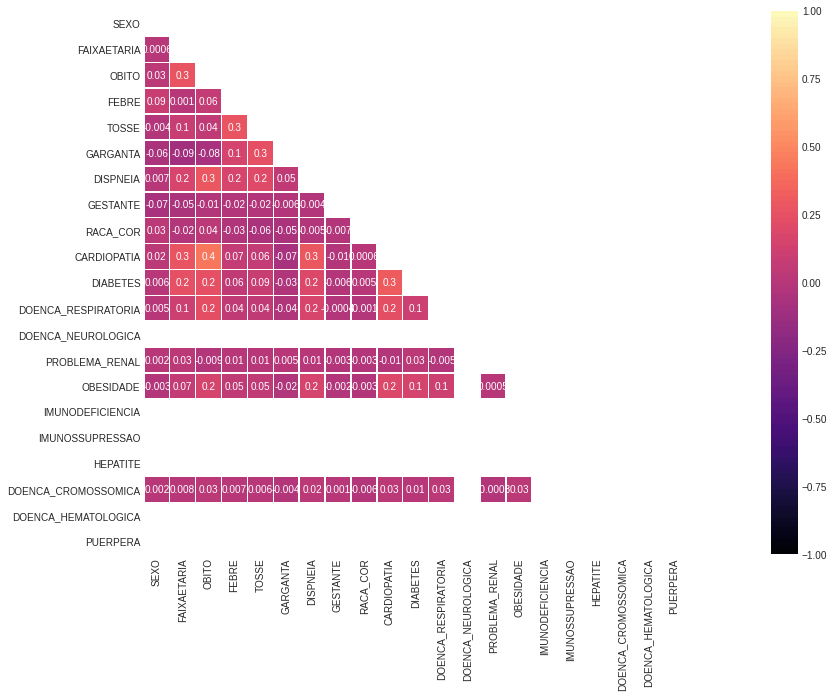

In [6]:
# matriz de correlacao
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,10)) 

# gerando mascara para a diagonal superior ficar vazia
mask = np.zeros_like(df.corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(method='pearson'), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("magma", 100), 
            mask=mask, 
            annot=True,
            fmt='.1g',
            linewidths=.5);

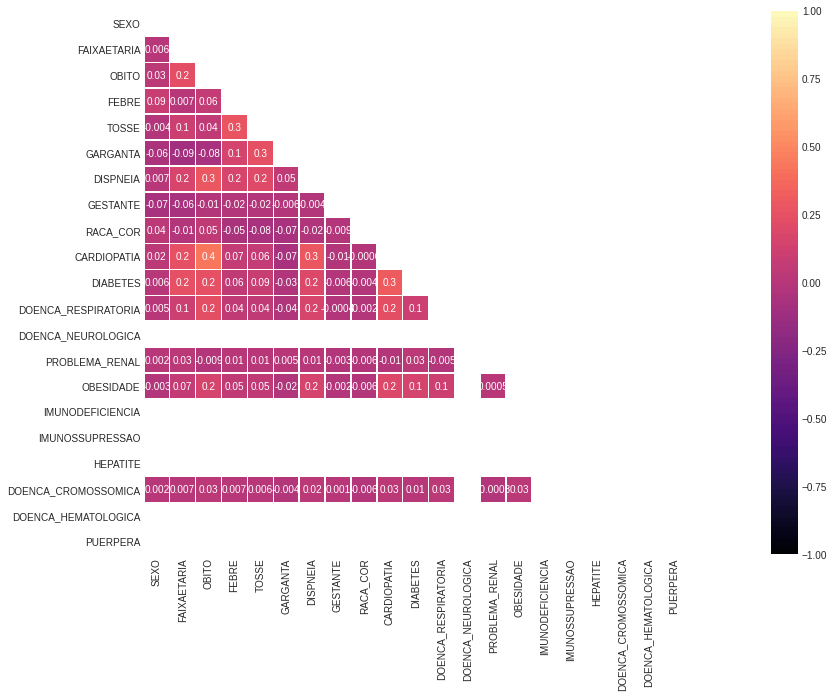

In [7]:
# matriz de correlacao
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,10)) 

# gerando mascara para a diagonal superior ficar vazia
mask = np.zeros_like(df.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(method='spearman'), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("magma", 100), 
            mask=mask, 
            annot=True,
            fmt='.1g',
            linewidths=.5);

### Chi Square

Chi-Quadrado (ou também chamado de Chi-Squared).

Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados desviam dos valores observados.

Quando temos um alto valor de Chi-quadrado (nosso p-value será baixo), significa que temos evidência estatística para inferir que os valores observados e esperados não são os mesmos, portanto possuem dependência entre si.

Quanto mais alto o Chi-quadrado, maior a dependência entre as variáveis.

In [8]:
X = df.drop(['OBITO'], axis=1)
y = df['OBITO']

# Calculando Chi-Squared
chi_scores = chi2(X,y)

In [9]:
# Colocando label nos resultados para posterior plot
scores = pd.Series(chi_scores[0], index=X.columns)
pvalues = pd.Series(chi_scores[1], index=X.columns)

In [10]:
# Results
result = pd.DataFrame({'chi2':scores, 'p-value':pvalues})
result.sort_values(by='chi2', ascending=False)

,chi2,p-value
CARDIOPATIA,70973.355364,0.000000e+00
DISPNEIA,26859.156079,0.000000e+00
DIABETES,21882.491586,0.000000e+00
DOENCA_RESPIRATORIA,20377.698662,0.000000e+00
FAIXAETARIA,16626.277767,0.000000e+00
OBESIDADE,8551.606872,0.000000e+00
GARGANTA,1460.316690,0.000000e+00
FEBRE,935.647304,1.748600e-205
RACA_COR,440.718042,7.553929e-98
TOSSE,349.798700,4.687870e-78


In [21]:
result[result['p-value'] > 0.05]

,chi2,p-value


As variáveis com alto p-value, dizem que a variável é independente com a nossa variável resposta, e não pode ser considerada no modelo de treinamento

In [12]:
# removendo os valores com pvalue maiores que 0.05
df1 = df[result[result['p-value'] < 0.05].index]

In [18]:
df1 = pd.concat([df1, df['OBITO']], axis=1)

# Conclusão
Após as transformações e preprocessamento, vamos armazenar o data frame para construção do modelo posterior.

In [19]:
df1.to_csv("covid_11_marco_pre_process.csv", sep=';', index=False)

## [EXTRA] 4. Feature Importance arvores de decisão
Florestas aleatórias consistem em um conjunto de árvores de decisão. Cada nó na árvore de decisão é uma condição de uma variável única, que objetiva dividir o conjunto de dados em dois de forma que valores de resposta semelhantes estejam no mesmo conjunto. A medida com base na qual a condição ótima (máximo local) é escolhido é chamado de *impurity*. Ao treinar uma árvore, pode-se calcular quanto cada recurso diminui a impureza ponderada em uma árvore. Para uma floresta, a diminuição da impureza de cada característica pode ser calculada e as características são classificadas de acordo com esta medida. Esta é a medida classificação de *feature importance* exposta nas implementações da Random Forest do sklearn, e existe dentro de `feature_importances_`.

Vamos utilizar de uma floresta aleatória para entender a importância das características do nosso conjunto de dados.

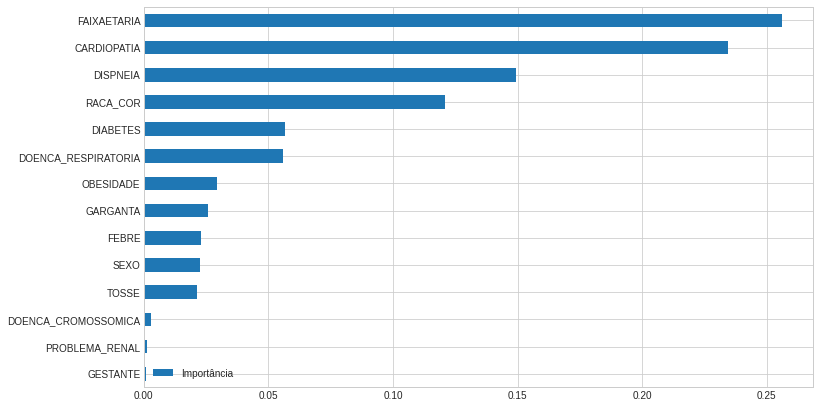

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df1.drop('OBITO', axis=1), df1['OBITO'])

plt.style.use('seaborn-whitegrid')
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=df1.drop('OBITO', axis=1).columns, columns=["Importância"])
importance.sort_values(by='Importância', ascending=True).plot(kind='barh', figsize=(12,len(importance)/2));